In [1]:
#generic import and constant definition list
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import h5py
import astropy.constants as cons
from matplotlib.colors import LogNorm
import astropy.units as u
import pandas as pd
import scipy.optimize as opt
#all of the important fundamental constants are put into cgs units just for convenience
c=cons.c.cgs.value
G=cons.G.cgs.value
h=cons.h.cgs.value
hbar=cons.hbar.cgs.value
Msun=cons.M_sun.cgs.value
Rsun=cons.R_sun.cgs.value
Rearth=cons.R_earth.cgs.value
mp=cons.m_p.cgs.value
me=cons.m_e.cgs.value
mn=cons.m_n.cgs.value
kB=cons.k_B.cgs.value
mu_e=2 #mean mass per electron for He-core or C/O core composition
m_u = 1/cons.N_A.cgs.value #atomic mass unit in grams
from astropy.io import fits

part b.) 

In [3]:
def eos1(rho):
    x = hbar*(3*np.pi**2*rho/mn)**(1/3)/ (mn*c)
    n_n = (x**3)/(3*(np.pi**2)*(hbar/(mn*c))**3) 
    phi = (1/(8*np.pi**2))*(x*np.sqrt(1+x**2)*(2*(x**2)/3 -1)+np.log(x+np.sqrt(1+x**2)))
    P = (mn*(c**2)/(hbar/(mn*c))**3)*phi
    return P

In [4]:
def eos2(rho):
    #n is in cm^-3
    return 5.83e35*((rho*1e-39/mn)**(2.54))

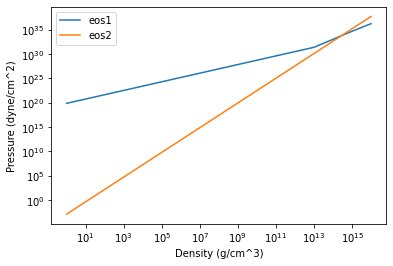

In [5]:
rho = np.linspace(1e0,1e16,1000)
P1 = eos1(rho)
P2 = eos2(rho)
plt.plot(rho,P1,label='eos1')
plt.plot(rho,P2,label='eos2')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Density (g/cm^3)')
plt.ylabel('Pressure (dyne/cm^2)')
plt.legend()
plt.show()

c.)

In [6]:
def eos1_zero(rho,Pin):
    x = hbar*(3*np.pi**2*rho/mn)**(1/3)/ (mn*c)
    n_n = (x**3)/(3*(np.pi**2)*(hbar/(mn*c))**3) 
    phi = (1/(8*np.pi**2))*(x*np.sqrt(1+x**2)*(2*(x**2)/3 -1)+np.log(x+np.sqrt(1+x**2)))
    P = (mn*(c**2)/(hbar/(mn*c))**3)*phi
    return P - Pin

In [7]:
def eos2_zero(rho,Pin):
    #n is in cm^-3
    return 5.83e35*((rho*1e-39/mn)**(2.54)) - Pin

In [10]:
def get_rho_from_P_eos1(P):
    guessRho = (P-1e10)/1e19
    rho1 = opt.fsolve(eos1_zero,guessRho,args= (P))
    return rho1

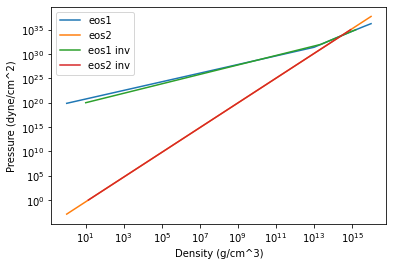

In [11]:
rho = np.linspace(1e0,1e16,1000)
P1 = eos1(rho)
P2 = eos2(rho)
plt.plot(rho,P1,label='eos1')
plt.plot(rho,P2,label='eos2')

P = np.linspace(1e20,1e35,1000)
#I got this guess just by eyeballing the plot and then messing around with it to get a linear approximation
rho1 = get_rho_from_P_eos1(P)
plt.plot(rho1,P,label='eos1 inv')

P = np.linspace(1e0,1e35,1000)
guessRho2 = ((P/5.83e35)**(1/2.54))*mn*1e39
plt.plot(guessRho2,P,label='eos2 inv')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Density (g/cm^3)')
plt.ylabel('Pressure (dyne/cm^2)')
plt.legend()
plt.show()

d.)

In [104]:
def dydr(m,P,phi,r,EOS):
    if EOS == 1:
        rho = get_rho_from_P_eos1(P)
    elif EOS == 2:
        rho = ((P/5.83e35)**(1/2.54))*mn*1e39
    #note that this is in the GR form from eqn 9.15-9.17 in the notes
    dmdr = 4*np.pi*(r**2)*rho
    dPdr = -G*(m+(4*np.pi*P*r**3)/c**2)*(rho+P/c**2)/((r**2)*(1-2*G*m/(r*c**2)))
    #dPdr = -G*m*rho/(r**2)
    dphidr = (G*m/((c**2)*r**2))*(1+(4*np.pi*P*r**3)/(m*c**2))/(1-2*G*m/(r*c**2))
    dphidr = G*m/(r**2)
    #print(dphidr)
    
    return np.array([dmdr,dPdr,dphidr])

e.)

In [105]:
def rk4_step(r, y, dr=0.5, EOS=1):
    #performs a single RK4 step
    #taken from my homework 1 and just slightly modified
    m = y[0]
    P = y[1]
    phi = y[2]
    
    k1 = dydr(m, P, phi, r, EOS=EOS)
    k2 = dydr(m + dr/2*k1[0], P + dr/2*k1[1], phi + dr/2*k1[2], r + dr/2, EOS=EOS)
    k3 = dydr(m + dr/2*k2[0], P + dr/2*k2[1], phi + dr/2*k2[2], r + dr/2, EOS=EOS)
    k4 = dydr(m + dr*k3[0], P + dr*k3[1], phi + dr*k3[2], r + dr, EOS=EOS)

    dm = (k1[0] + 2*k2[0] + 2*k3[0] + k4[0]) * dr / 6
    dP = (k1[1] + 2*k2[1] + 2*k3[1] + k4[1]) * dr / 6
    dphi = (k1[2] + 2*k2[2] + 2*k3[2] + k4[2]) * dr / 6
    m_new = m + dm
    P_new = P + dP
    phi_new = phi + dphi
    
    return m_new, P_new, phi_new

f.)

In [140]:
def integrate(r0,y0, dr=500, EOS=1):
    #taken from my homework 1 and modified slightly
    m0 = y0[0]
    P0 = y0[1]
    phi0 = y0[2]
    #maxIterations=Rsun/dr+10
    maxIterations=10000
    i=0
    r = np.array([r0])
    m = np.array([m0])
    P = np.array([P0])
    phi = np.array([phi0])
    P_central = P0
    while i < maxIterations:
        # Perform a single RK4 step
        m_new, P_new, phi_new = rk4_step(r[-1], np.array([m[-1], P[-1], phi[-1]]), dr=dr, EOS=EOS)
        # Update the values for the next iteration
        r = np.append(r, r[-1] + dr)
        m = np.append(m, m_new)
        P = np.append(P, P_new)
        phi = np.append(phi, phi_new)
        # Check for stopping condition (the pressure is 10^-10 of the central pressure)
        if P[-1]/P_central < 1e-10:
            return r, m, P, phi
        i += 1
    print("Maximum iterations reached in integrate_star. Returning last values.")
    return r, m, P, phi

g.)

test case:

/home/tegan/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/home/tegan/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  
/home/tegan/anaconda3/envs/research/lib/python3.6/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


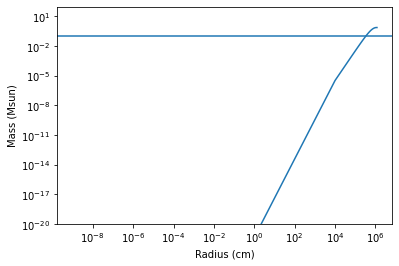

In [ ]:
P0 = 1e34
dr = 1e4
#I'm starting with random initial central pressure just to see if the code runs and an initial mass of electon mass so its tiny but not 0 (so I won't get nans)
r, m, P, phi = integrate(1e-9, np.array([mn, P0, 0]), dr=dr, EOS=1)
plt.plot(r, m/Msun)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-20,1e2)
plt.axhline(y=0.103)
plt.xlabel('Radius (cm)')
plt.ylabel('Mass (Msun)')
plt.show()

/home/tegan/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/home/tegan/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  
/home/tegan/anaconda3/envs/research/lib/python3.6/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Maximum iterations reached in integrate_star. Returning last values.


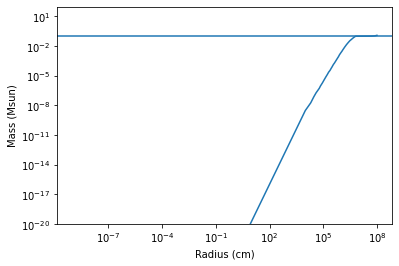

In [143]:
P0 = 1e30
dr = 1e4
#I'm starting with random initial central pressure just to see if the code runs and an initial mass of electon mass so its tiny but not 0 (so I won't get nans)
r, m, P, phi = integrate(1e-9, np.array([mn, P0, 0]), dr=dr, EOS=1)
plt.plot(r, m/Msun)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-20,1e2)
plt.axhline(y=0.103)
plt.xlabel('Radius (cm)')
plt.ylabel('Mass (Msun)')
plt.show()

/home/tegan/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/home/tegan/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  


Maximum iterations reached in integrate_star. Returning last values.


/home/tegan/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/home/tegan/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  
/home/tegan/anaconda3/envs/research/lib/python3.6/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Maximum iterations reached in integrate_star. Returning last values.


/home/tegan/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/home/tegan/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  
/home/tegan/anaconda3/envs/research/lib/python3.6/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/tegan/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different length

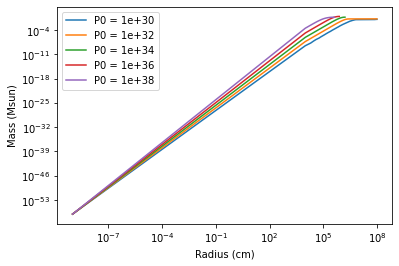

In [151]:
P0 = 1e30
dr = 1e4
#I'm starting with random initial central pressure just to see if the code runs and an initial mass of electon mass so its tiny but not 0 (so I won't get nans)
for Pc in np.logspace(30,38,5):
    r, m, P, phi = integrate(1e-9, np.array([mn, Pc, 0]), dr=dr, EOS=1)
    plt.plot(r, m/Msun,label="P0 = "+str(Pc))
#r, m, P, phi = integrate(1e-9, np.array([mn, P0, 0]), dr=dr, EOS=1)
#plt.plot(r, m/Msun)
plt.xscale('log')
plt.yscale('log')
#plt.ylim(1e-20,1e2)
#plt.axhline(y=0.103)
plt.xlabel('Radius (cm)')
plt.ylabel('Mass (Msun)')
plt.legend()
plt.show()

/home/tegan/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/home/tegan/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  
/home/tegan/anaconda3/envs/research/lib/python3.6/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Maximum iterations reached in integrate_star. Returning last values.
Maximum iterations reached in integrate_star. Returning last values.


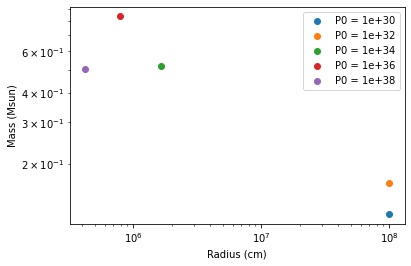

In [152]:
P0 = 1e30
dr = 1e4
#I'm starting with random initial central pressure just to see if the code runs and an initial mass of electon mass so its tiny but not 0 (so I won't get nans)
for Pc in np.logspace(30,38,5):
    r, m, P, phi = integrate(1e-9, np.array([mn, Pc, 0]), dr=dr, EOS=1)
    plt.scatter(r[-1], m[-1]/Msun,label="P0 = "+str(Pc))
#r, m, P, phi = integrate(1e-9, np.array([mn, P0, 0]), dr=dr, EOS=1)
#plt.plot(r, m/Msun)
plt.xscale('log')
plt.yscale('log')
#plt.ylim(1e-20,1e2)
#plt.axhline(y=0.103)
plt.xlabel('Radius (cm)')
plt.ylabel('Mass (Msun)')
plt.legend()
plt.show()

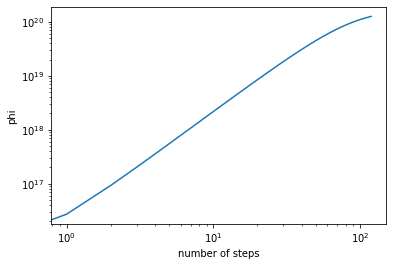

In [118]:
plt.plot((r-1e-9)/dr,phi)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('phi')
plt.xlabel('number of steps')
plt.show()

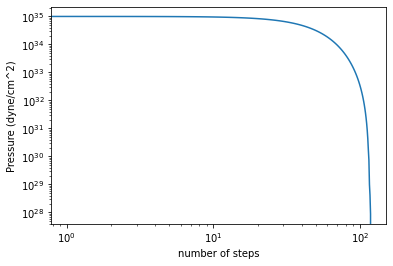

In [119]:
plt.plot((r-1e-9)/dr,P)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('number of steps')
plt.ylabel('Pressure (dyne/cm^2)')
plt.show()
